# Running cross-validation to estimate performance of system

In [1]:
# Import
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
%matplotlib inline


load_loc = '/home/sfvn/Dropbox/DeepFactData/annotated/' #SPECIFY PATH TO DATA
with open(load_loc+"data_matrix_sample_programs.pickle",'rb') as f:
        data = pickle.load(f)

In [2]:
X = data['data'][:,4] # sentences
y = data['data'][:,6] # claim indices
N = len(X)

features = data['features']
print(features)

# Now convert y to a binary indicator matrix (1 is claim, 0 no claim)
y = np.asarray([y[i] is not None for i in range(N)])

# Make a Bag-of-Words
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)
words = vectorizer.get_feature_names()

# Fit the logit model
logistic = linear_model.LogisticRegression()
logistic.fit(X=X_bow,y=y)
ypred = logistic.predict(X_bow) 

# CM on traning data
C = confusion_matrix(y, ypred)
C


['start time', 'end time', 'program_id', 'sentence_id', 'sentence', 'claim_idx', 'claim']


array([[2346,    0],
       [  76,  123]])

/home/sfvn/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


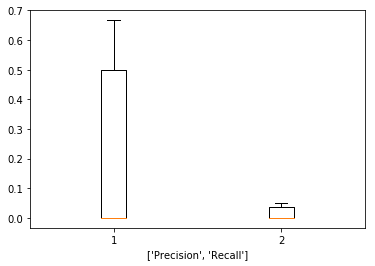

In [3]:
# Get number of programs
program_ids = data['data'][:,2]
unique_programs = np.unique(program_ids)
NUM_PROGRAMS = len(unique_programs)                   
loo = LeaveOneOut()

class_performance_precision = []
class_performance_recall = []

for train,test in loo.split(unique_programs):
    # Extract training and test data
    train_idx = program_ids!=unique_programs[test]
    test_idx = program_ids==unique_programs[test]
    X_test = X_bow[test_idx]
    X_train = X_bow[train_idx]
    y_test = y[test_idx]
    y_train = y[train_idx]
    
    # Train model
    logistic = linear_model.LogisticRegression()
    logistic.fit(X=X_train,y=y_train)
    ypred = logistic.predict(X_test) 

    # Evaluate
    class_performance_precision += [precision_score(y_test,ypred)]
    class_performance_recall += [recall_score(y_test,ypred)]

plt.boxplot( [class_performance_precision, class_performance_recall] )
plt.xlabel( ['Precision', 'Recall'])
plt.show()

In [4]:
unique_programs

array(['program1', 'program2', 'program3', 'program4', 'program5',
       'program6', 'program7'], dtype=object)

## Cross-validation with Tensorflow

In [5]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
import numpy as np

def leave_one_program_out_cv(data, model_list, eval_functions = [accuracy_score]):
    # TODO: Change model_list to class_list and initialize objects in model-loop
    # Get program ids and number of programs
    program_ids = data['data'][:,2]
    unique_programs = np.unique(program_ids)
    NUM_PROGRAMS = len(unique_programs)                   
    loo = LeaveOneOut()
    classification_results = np.empty( (NUM_PROGRAMS, len(model_list), len(eval_functions)))
    classification_results.fill(np.nan)
    
    # Loop over programs
    p = 0
    for train,test in loo.split(unique_programs):
        train_idx = program_ids!=unique_programs[test]
        test_idx = program_ids==unique_programs[test]
        
        print('Welcome to program %i' %(p+1) )
        print('Number of training examples %i'%(np.sum(train_idx)) )
        print('Number of test examples %i'%(np.sum(test_idx)) )

        training_data, test_data = data_to_tensors(data, train_idx, test_idx)
        m = 0
        for model in model_list:
            # Initalizize TF.seesion... and clear previous?
            tfsess = tf.Session()
            model.fit(training_data, tfsess)
            y_pred = model.predict(test_data, tfsess)
            # Evaluate with eval_functions
            e=0
            for evalf in eval_functions:
                classification_results[p,m,e] = evalf(test_data['labels'], y_pred)
                e += 1
                
            m+=1
        
        print("Done with training and evaluation! ---")
        p+=1
    return classification_results
    
def data_to_tensors(data, train_indices=None, test_indices=None):
    # TODO: embedding input (string 'bow', 'word2vec', 'glove', ... )
    # Performs neccesary feature extraction and test/training split
    # Returns data transformed in multiple ways tensors: 
    #    char: Char-based 
    #    pos: Part-of-Speech tagging
    #    word2vec: Word2vec (or someother subspace..)
    #    bow: Bag-Of-Words
    # Furthermore returns for each sample the binary vector y (labels)
    
    data_train = dict()
    data_test = dict()
    
    # Extract relevant data from table
    X = data['data'][:,4] # sentences
    y = data['data'][:,6] # claim indices
    N = len(X)

    # If no test/train split is specified return everything in training
    if train_indices is None and test_indices is None:
        train_indices=np.ones(N, dtype=bool)
        

    # Pr. sample label-vector    
    y = np.asarray([y[i] is not None for i in range(N)])    
    data_train['labels'] = y[train_indices]
    if train_indices is not None and test_indices is not None:
        data_test['labels'] = y[test_indices]

    
    # Char
    # ...
    
    # Pos
    # ...
    
    # Word2Vec
    # ...
    
    # Bag-Of-Words
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(X)
    data_train['bow'] = X_bow[train_indices,:]
    if train_indices is not None and test_indices is not None:
        data_test['bow']= X_bow[test_indices,:]
    
    
    return data_train, data_test


#class TensorFlowModel:
        
    
    


In [6]:
import sys
sys.path.append('..')
from mymodels.baselines import MyLogisticRegression
    

In [7]:
from sklearn.metrics import f1_score
leave_one_program_out_cv(data, [MyLogisticRegression()], eval_functions=[accuracy_score, f1_score])

Welcome to program 1
Number of training examples 2029
Number of test examples 516
Epoch: 0001 cost= 0.052224949
Epoch: 0002 cost= 0.052222583
Epoch: 0003 cost= 0.052221563
Epoch: 0004 cost= 0.052220561
Epoch: 0005 cost= 0.052218858
Optimization Finished!
Done with training and evaluation! ---
Welcome to program 2
Number of training examples 2225
Number of test examples 320


/home/sfvn/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 0001 cost= 0.051657040
Epoch: 0002 cost= 0.051655069
Epoch: 0003 cost= 0.051654309
Epoch: 0004 cost= 0.051653452
Epoch: 0005 cost= 0.051651634
Optimization Finished!
Done with training and evaluation! ---
Welcome to program 3
Number of training examples 2103
Number of test examples 442
Epoch: 0001 cost= 0.059261095
Epoch: 0002 cost= 0.059258666
Epoch: 0003 cost= 0.059257809
Epoch: 0004 cost= 0.059256326
Epoch: 0005 cost= 0.059253622
Optimization Finished!
Done with training and evaluation! ---
Welcome to program 4
Number of training examples 2228
Number of test examples 317
Epoch: 0001 cost= 0.052851539
Epoch: 0002 cost= 0.052849550
Epoch: 0003 cost= 0.052848786
Epoch: 0004 cost= 0.052847899
Epoch: 0005 cost= 0.052846048
Optimization Finished!
Done with training and evaluation! ---
Welcome to program 5
Number of training examples 2236
Number of test examples 309
Epoch: 0001 cost= 0.049242124
Epoch: 0002 cost= 0.049240317
Epoch: 0003 cost= 0.049239483
Epoch: 0004 cost= 0.04923865

array([[[ 0.91085271,  0.        ]],

       [[ 0.896875  ,  0.        ]],

       [[ 0.95701357,  0.        ]],

       [[ 0.90851735,  0.        ]],

       [[ 0.87055016,  0.        ]],

       [[ 0.94011976,  0.        ]],

       [[ 0.96091205,  0.        ]]])

In [9]:
tensors = data_to_tensors(data)

TypeError: tuple indices must be integers or slices, not str